See https://examples.dask.org/applications/embarrassingly-parallel.html.

In [1]:
import time
import xarray as xr
from glob import glob
from memory_profiler import memory_usage
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
import spatialproteomics as sp
from tqdm.auto import tqdm
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import matplotlib as mpl
import gc

mpl.style.core.use('/g/huber/users/meyerben/notebooks/spatialproteomics_pipelines/spatialproteomics_bnhl/figures/pub_matplotlib_rc.ini')
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

# --- Global style ---
mpl.rcParams.update({
    "font.size": font_size,        # for labels, ticks, legends
    "axes.labelsize": font_size,   # axis labels
    "xtick.labelsize": font_size,  # x tick labels
    "ytick.labelsize": font_size,  # y tick labels
    "legend.fontsize": font_size,  # legend text
    "lines.linewidth": line_width, # default line width
    "axes.linewidth": line_width,  # axes border width
    "grid.linewidth": line_width   # grid lines
})

In [3]:
# --- Input files ---
all_files = glob('../250902_thresholds_for_revisions/for_nora_and_nicklas/selected_zarrs/*.zarr')

# --- Define processing function ---
def process_file(path):
    # ensure accessor available in subprocess
    import spatialproteomics as sp  
    ds = (xr.open_zarr(path)
          .pp.add_quantification(func="intensity_mean")
          .pp.transform_expression_matrix(method="arcsinh"))
    return ds  # lazy is fine

# --- Benchmark helper ---
def benchmark(name, func, *args, **kwargs):
    start = time.perf_counter()
    mem, result = memory_usage((func, args, kwargs),
                               max_usage=True, retval=True)
    end = time.perf_counter()
    return {
        "method": name,
        "runtime_sec": end - start,
        "peak_mem_mb": mem,
        "n_files": len(args[0]) if args else None
    }

# --- Sequential ---
def run_sequential(files):
    results = []
    for f in tqdm(files, desc="Sequential"):
        results.append(process_file(f))
    return results

# --- Parallel ---
def run_parallel(files):
    tasks = [delayed(process_file)(f) for f in tqdm(files, desc="Scheduling")]
    results = compute(*tasks, scheduler="processes", num_workers=16)
    return results

In [4]:
# --- Run benchmarks for different sizes ---
results = []
for n in [5, 10, 20, 30, 40]:
    files = all_files[:n]
    results.append(benchmark("Sequential", run_sequential, files))
    gc.collect()
    results.append(benchmark("Parallel", run_parallel, files))
    gc.collect()

# Convert to DataFrame
df = pd.DataFrame(results)
df

Sequential:   0%|          | 0/5 [00:00<?, ?it/s]

Scheduling:   0%|          | 0/5 [00:00<?, ?it/s]

Sequential:   0%|          | 0/10 [00:00<?, ?it/s]

Scheduling:   0%|          | 0/10 [00:00<?, ?it/s]

Sequential:   0%|          | 0/20 [00:00<?, ?it/s]

Scheduling:   0%|          | 0/20 [00:00<?, ?it/s]

Sequential:   0%|          | 0/30 [00:00<?, ?it/s]

Scheduling:   0%|          | 0/30 [00:00<?, ?it/s]

Sequential:   0%|          | 0/40 [00:00<?, ?it/s]

Scheduling:   0%|          | 0/40 [00:00<?, ?it/s]

,method,runtime_sec,peak_mem_mb,n_files
0,Sequential,14.608655,1527.066406,5
1,Parallel,14.779498,746.730469,5
2,Sequential,25.982574,1787.640625,10
3,Parallel,18.542374,1108.570312,10
4,Sequential,49.228731,1896.121094,20
5,Parallel,20.883604,1325.015625,20
6,Sequential,64.556133,1935.218750,30
7,Parallel,21.594461,1446.144531,30
8,Sequential,81.110408,1990.644531,40
9,Parallel,25.193450,1408.824219,40


In [5]:
df.to_csv("results/dask_parallelization/benchmark_results.csv", index=False)

In [3]:
df = pd.read_csv("results/dask_parallelization/benchmark_results.csv")

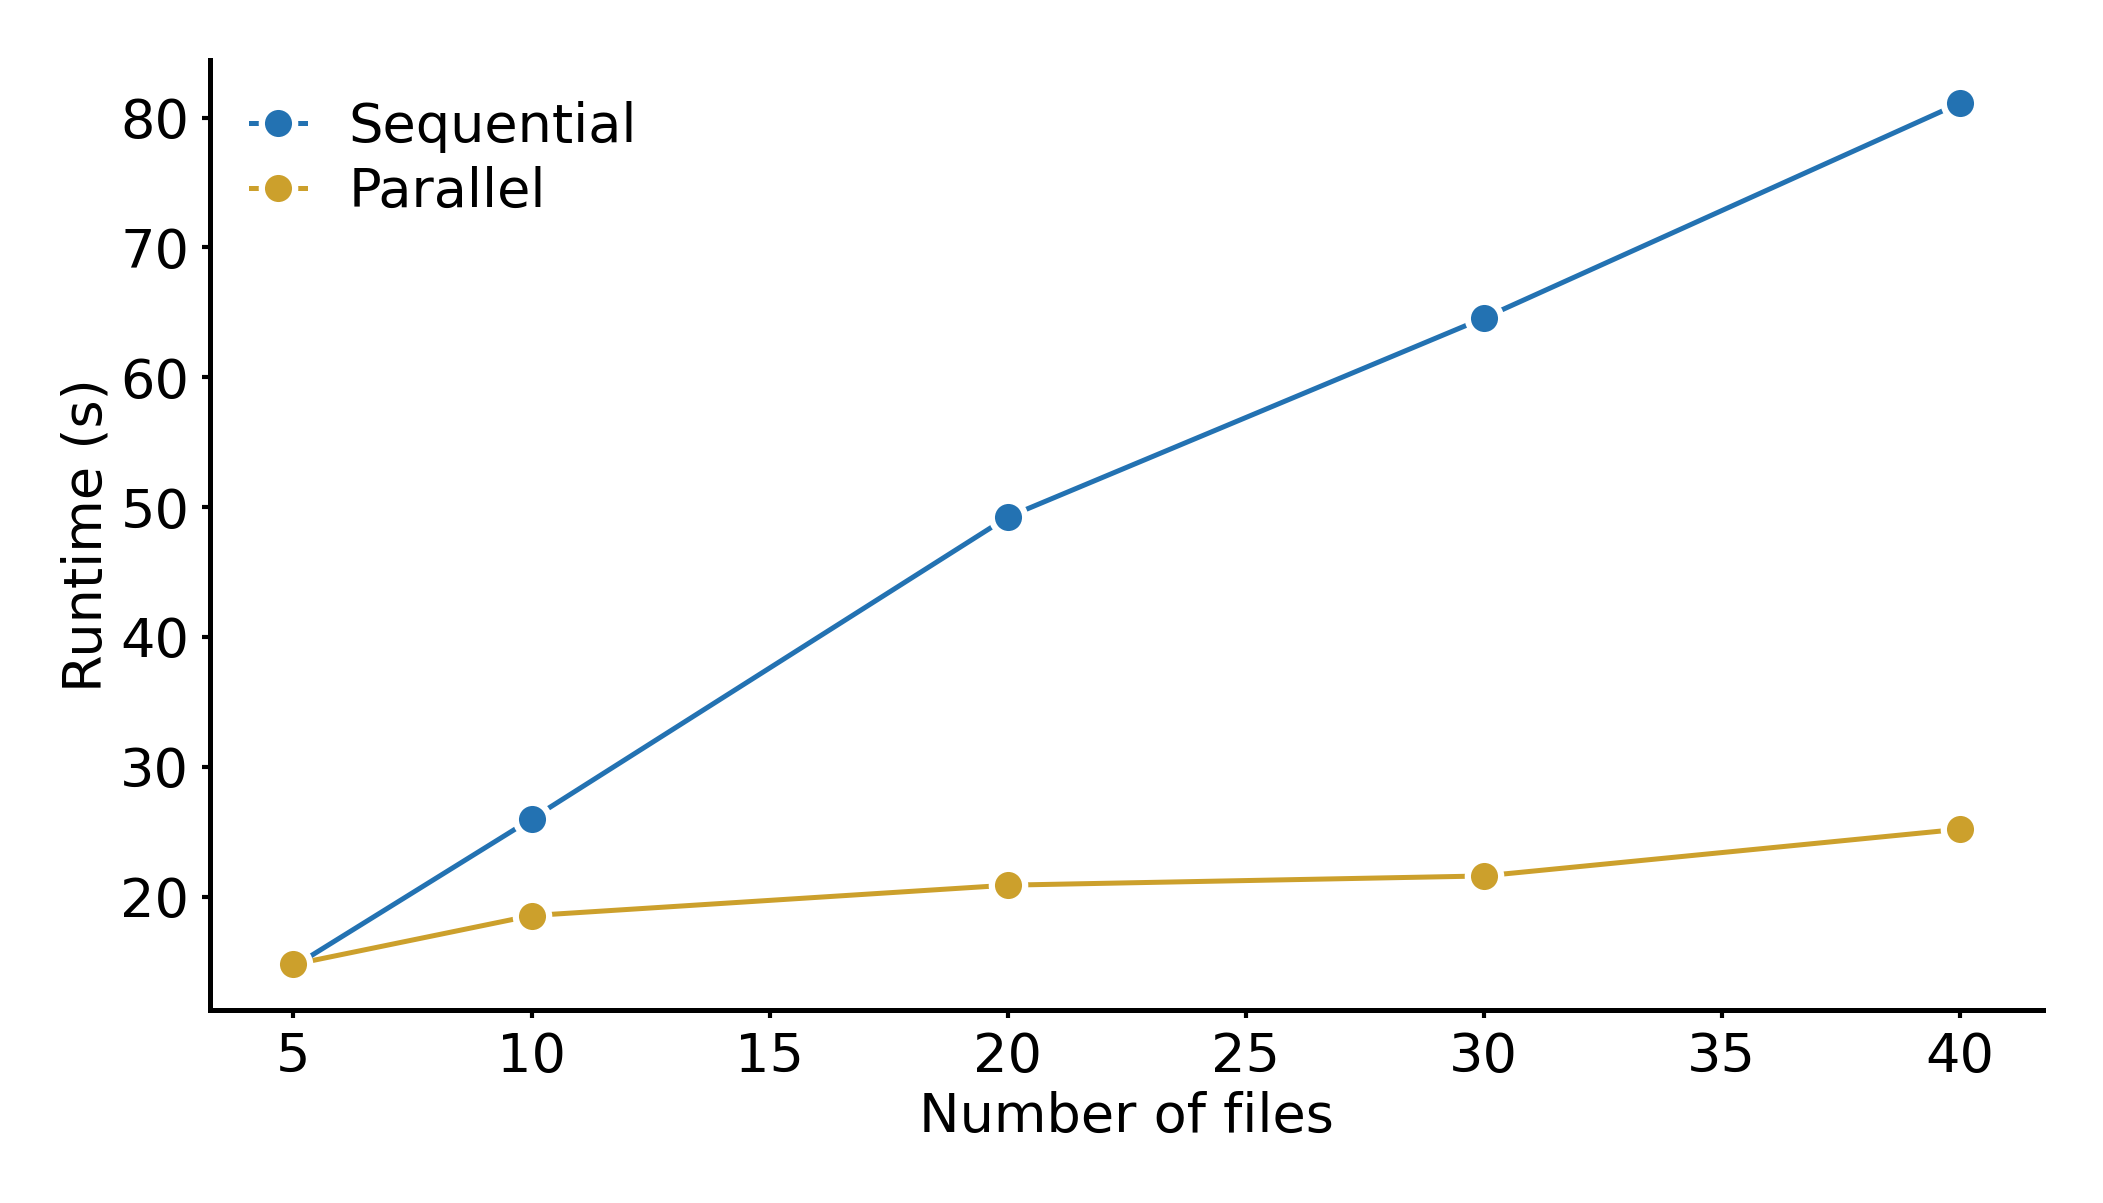

In [4]:
# independent plots for figure
from matplotlib.lines import Line2D

custom_colors = {
    "Sequential": "#2372b2",  # blue
    "Parallel": "#cca02c",  # orange
}

fig, ax = plt.subplots(figsize=(3.5, 2), dpi=600)
sns.lineplot(
    data=df,
    x="n_files",
    y="runtime_sec",
    hue="method",
    marker="o",
    linewidth=line_width,
    markersize=4,
    palette=custom_colors
)
ax.set_xlabel("Number of files")
ax.set_ylabel("Runtime (s)")
sns.despine()
ax.legend(title=None)

plt.tight_layout()
plt.savefig('figs/supp_fig_7c.svg', bbox_inches='tight', pad_inches=0)
# plt.savefig('figs/supp_fig_7c.png', bbox_inches='tight', pad_inches=0)
plt.show()

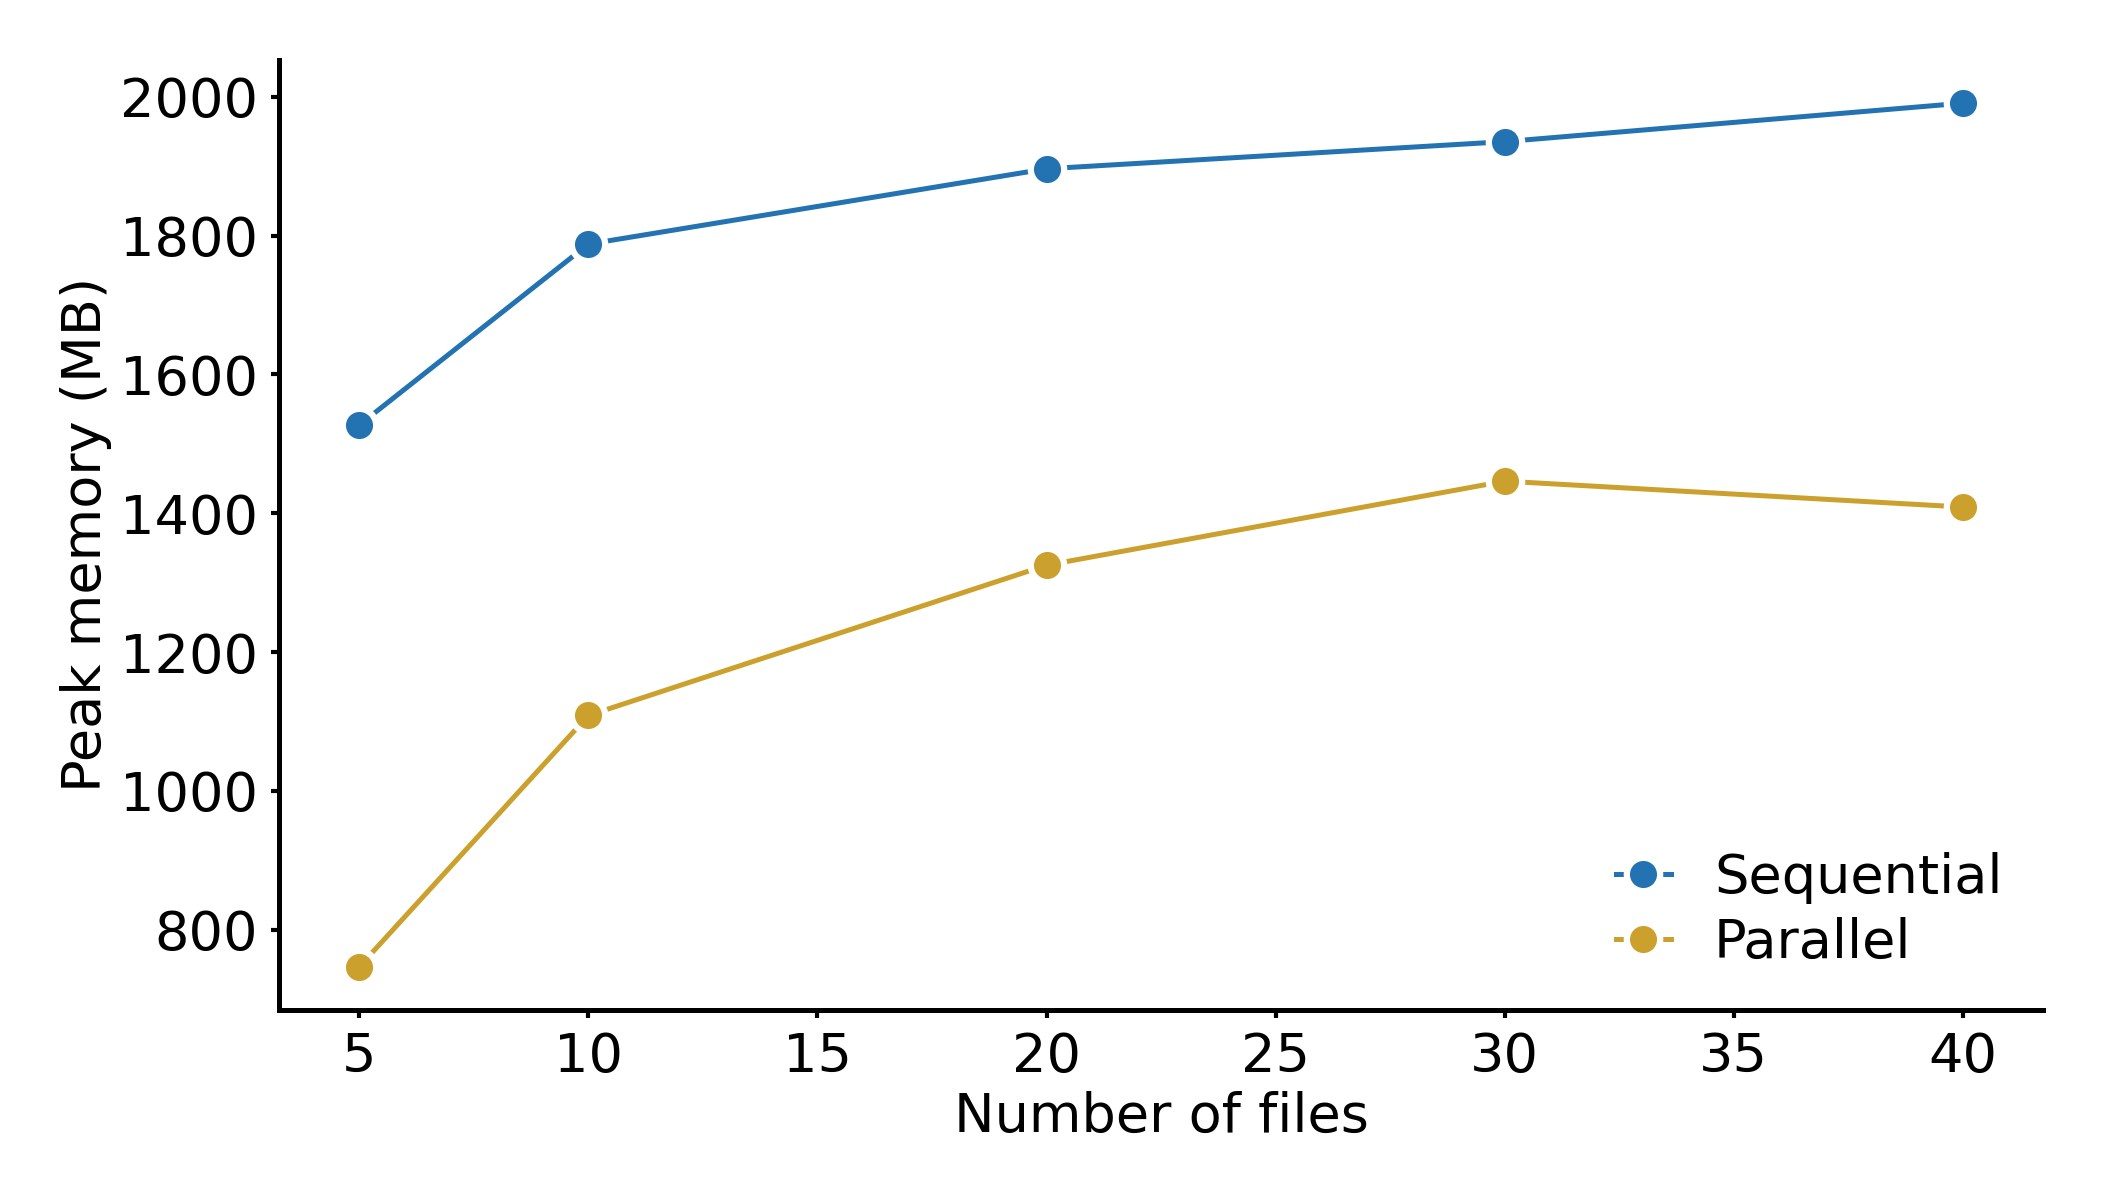

In [5]:
# same plot but for memory consumption

fig, ax = plt.subplots(figsize=(3.5, 2), dpi=600)
sns.lineplot(
    data=df,
    x="n_files",
    y="peak_mem_mb",
    hue="method",
    marker="o",
    linewidth=line_width,
    markersize=4,
    palette=custom_colors
)
ax.set_xlabel("Number of files")
ax.set_ylabel("Peak memory (MB)")
sns.despine()
ax.legend(title=None)

plt.tight_layout()
plt.savefig('figs/supp_fig_7d.svg', bbox_inches='tight', pad_inches=0)
plt.show()